# DC-$\pi$BO - Stationary DAG and SCM but with node out-degree $\geq 1$

## Imports

In [25]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append("../src/")
sys.path.append("..")

from src.utils.sequential_sampling import sequentially_sample_model
from src.examples.example_setups import setup_stat_multiple_children_scm
from src.utils.sem_utils.toy_sems import StationaryDependentMultipleChildrenSEM as TestSEM
from src.utils.plotting import plot_outcome
from src.utils.sem_utils.sem_estimate import build_sem_hat
from src.utils.utilities import powerset, get_monte_carlo_expectation
from src.utils.sequential_intervention_functions import make_sequential_intervention_dict

from src.methods.bo import BO
from src.methods.dcbo import DCBO
from src.methods.pibo import PIBO
from src.methods.dcpibo import DCPIBO

import numpy as np
from numpy import zeros
import matplotlib.pyplot as plt
from scipy import stats
import random

random.seed(42)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Constants and such

In [26]:
T = 3 # number of time-steps
t_axis = np.linspace(1,T,T,dtype=int) # the actual time-steps
N = 10 # number of trials
std_strong = 0.1 # standard deviation of the prior 𝜋 in the strong case
std_weak = 0.5 # standard deviation of the prior 𝜋 in the weak case
beta = 1 # set as N/10

## Optima location

In [27]:
a_param_good = -2
b_param_good = 0
y_good = a_param_good*t_axis+b_param_good # the line on which I assume the optima would be

a_param_bad = 1
b_param_bad = 1.5
y_bad = a_param_bad*t_axis+b_param_bad

## Utility Functions

In [28]:
def power_list(input_list, exponent):
    '''Raises each element of the given input_list to the desired exponent'''
    
    return_list = []
    
    for element in input_list:
        if element >= 0:
            raised_element = element**exponent
        else:
            raised_element = -(abs(element)**exponent)
        return_list.append(raised_element)
        
    return return_list

In [29]:
def compute_statistics(y_function, standard_deviation):
    '''Computes all the necessary lists associated to the Normal Distribution'''
    
    return_variates = []
    return_amps = []
    return_pdfs = []
    
    for mean in y_function:
        return_variates.append(stats.norm.rvs(mean, standard_deviation, 10))
        
        amp = np.linspace(mean-5*standard_deviation, mean+5*standard_deviation, 10)
        return_amps.append(amp)
        
        return_pdfs.append(stats.norm.pdf(amp, mean, standard_deviation))
    
    return return_variates, return_amps, return_pdfs

In [30]:
def normalise_pdfs(pdfs_list):
    '''Normalises the PDFs between 0 and 1'''
    
    return_normalised_pdfs_list = []
    
    for pdf_list in pdfs_list:
        temp_list = []
        
        pdf_min = min(pdf_list)
        pdf_max = max(pdf_list)
        
        for pdf_value in pdf_list:
            temp_list.append(round((pdf_value-pdf_min)/(pdf_max-pdf_min),2))
        
        return_normalised_pdfs_list.append(temp_list)
        
    return return_normalised_pdfs_list

In [31]:
def regret_priors(start_prior):
    '''Adds regret'''
    
    return_raised_priors = []
    
    for i in range(1,N+1):
        temp = []
        gamma = beta/i
        
        for p_list in start_prior:
            temp.append(power_list(p_list, gamma))
            
        return_raised_priors.append(temp)
    
    return return_raised_priors

In [32]:
def predict_optima(time_steps, variates, normalised_pdfs):
    '''Predicts the optimum for each time-step'''
    
    return_prediction = []
    
    for time_step in range(time_steps):
        if(min(variates[time_step])+max(variates[time_step]))<0:
            optimum = min(variates[time_step]*normalised_pdfs[time_step])
        else:
            optimum = max(variates[time_step]*normalised_pdfs[time_step])
        return_prediction.append(optimum)
        
    return return_prediction

In [33]:
def predict_optima_regret(iterations, time_steps, regret_priors, normalised_pdfs):
    '''Computes the prediction for each time-step and each iteration, according to the effect of gamma (regret)'''
    
    return_predictions = []
    
    for iteration in range(iterations):
        temp = []
        
        for time_step in range(time_steps):
            if(min(regret_priors[iteration][time_step])+max(regret_priors[iteration][time_step]))<0:
                optimum = min(np.multiply(regret_priors[iteration][time_step], normalised_pdfs[time_step]))
            else:
                optimum = max(np.multiply(regret_priors[iteration][time_step], normalised_pdfs[time_step]))
                              
            temp.append(optimum)
                              
        return_predictions.append(temp)
                              
    return return_predictions

## Setup

Concerning the prior:

In [34]:
all_variates, all_amps, all_pdfs = compute_statistics(y_good, std_strong)
all_variates_regret = regret_priors(all_variates)

all_pdfs_normalised = normalise_pdfs(all_pdfs)

predicted_optima = predict_optima(T, all_variates, all_pdfs_normalised)
predicted_optima_regret = predict_optima_regret(N, T, all_variates_regret, all_pdfs_normalised) # this are all the 𝜋s

In [35]:
all_bad_variates, all_bad_amps, all_bad_pdfs = compute_statistics(y_bad, std_strong)
all_bad_variates_regret = regret_priors(all_bad_variates)

all_bad_pdfs_normalised = normalise_pdfs(all_bad_pdfs)

predicted_bad_optima = predict_optima(T, all_bad_variates, all_bad_pdfs_normalised)
predicted_bad_optima_regret = predict_optima_regret(N, T, all_bad_variates_regret, all_bad_pdfs_normalised)

Concerning the models:

In [36]:
init_sem, sem, dag_view, G, exploration_sets, intervention_domain, true_objective_values, optimal_interventions, all_causal_effects  = setup_stat_multiple_children_scm(T=T)

In [37]:
# Number of independent samples per time-index
D_O = sequentially_sample_model(init_sem,
                                sem,
                                total_timesteps=T,
                                sample_count=10,
                                epsilon=None)

In [38]:
# Simulate some interventional data
D_I = {k: None for k in powerset(["X", "Z"])}
"""
do(Z_0)
"""
interv = make_sequential_intervention_dict(G,T)
# Univariate intervention at time 0
interv["Z"][0] = 1.0
static_noise_model = {k: zeros(T) for k in ["X", "Z", "Y"]}
# Sample this model with one intervention, and no noise
intervention_samples = sequentially_sample_model(
    init_sem,
    sem,
    total_timesteps=T,
    interventions=interv,
    sample_count=1,
    epsilon=static_noise_model
)

# Note: we obvs don't need to take MC samples if noise-model is zero
D_I[("Z",)] = get_monte_carlo_expectation(intervention_samples)

## Models' executions

### BO

In [39]:
BO_input_params = {
    "G": G,
    "sem": TestSEM, 
    "base_target_variable": "Y",
    # "exploration_sets":exploration_sets,
    "observation_samples": D_O,
    "intervention_domain": intervention_domain,
    "intervention_samples":None,
    "number_of_trials": N,
    "sample_anchor_points": True,
    "seed_anchor_points": 1,
}

Time index: 100%|██████████████████████████████████████████████████| 3/3 [00:00<00:00,  6.24it/s]


In [ ]:
# Run BO
bo = BO(**BO_input_params)
bo.run()

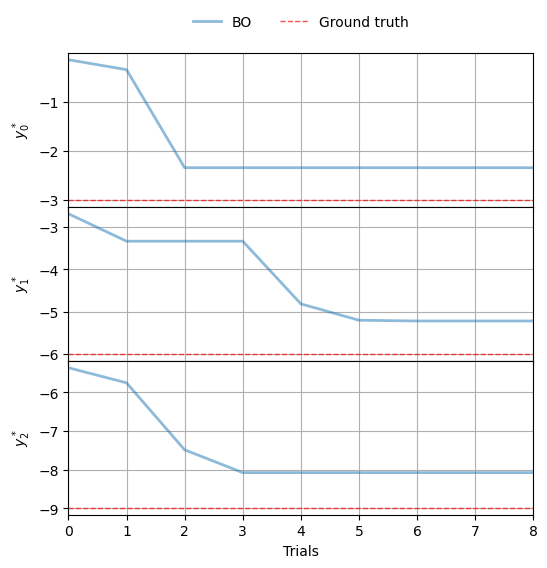

In [40]:
plot_outcome(T,N,outcomes=[bo.optimal_outcome_values_during_trials],labels=['BO'],true_objective_values=true_objective_values)

### DCBO

In [41]:
DCBO_input_params = {
    "G": G,
    "sem": TestSEM, 
    "base_target_variable": "Y",
    "make_sem_estimator": build_sem_hat,
    "exploration_sets":exploration_sets,
    "observation_samples": D_O,
    "intervention_domain": intervention_domain,
    "intervention_samples":None,
    "number_of_trials": N,
    "sample_anchor_points": True,
    "seed_anchor_points": 1,
}

In [42]:
# Run DCBO
dcbo = DCBO(**DCBO_input_params)
dcbo.run()

 /mnt/c/Users/lucal/Desktop/Thesis/DCBO/DCBO/notebooks/../src/utils/dag_utils/adjacency_matrix_utils.py:26: FutureWarning:adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
 /home/luca/miniconda3/envs/MTL_DCBO_testing/lib/python3.10/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /home/luca/miniconda3/envs/MTL_DCBO_testing/lib/python3.10/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in divide
 /home/luca/miniconda3/envs/MTL_DCBO_testing/lib/python3.10/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply
Time index:   0%|                                                          | 0/3 [00:00<?, ?it/s]reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
Time index:  33%|████████████████▋                                 | 1/3 [00:03<00:07,  

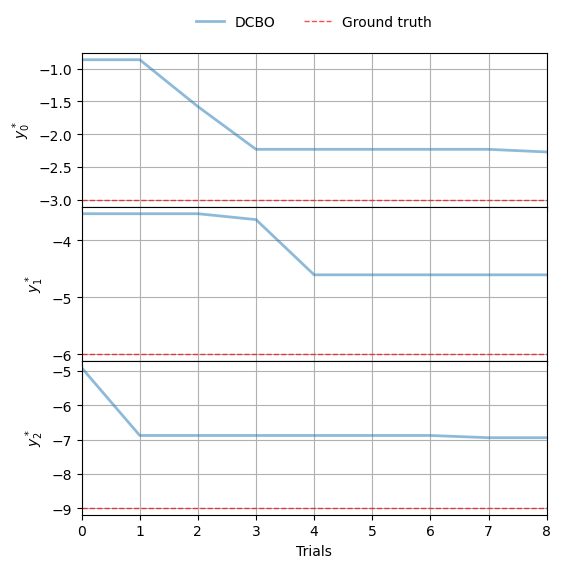

In [43]:
plot_outcome(T,N,outcomes=[dcbo.optimal_outcome_values_during_trials],labels=['DCBO'],true_objective_values=true_objective_values)

### $\pi$BO

In [48]:
# Run PIBO
pibo = PIBO(**BO_input_params)
pibo.run(predicted_bad_optima_regret)

Time index: 100%|██████████████████████████████████████████████████| 3/3 [00:00<00:00,  5.60it/s]


<Figure size 1500x1500 with 0 Axes>

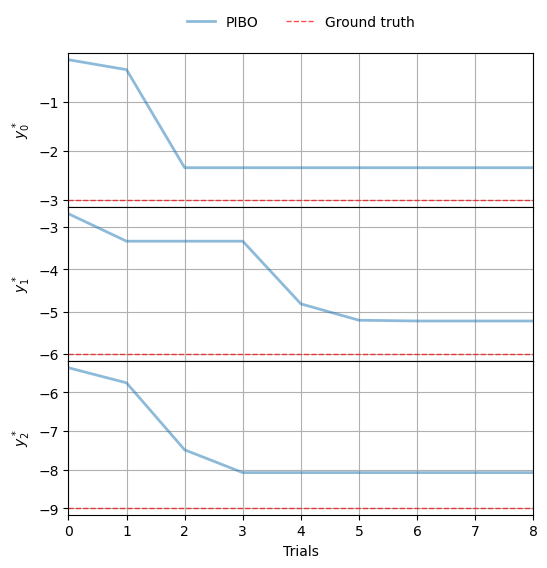

In [49]:
plot_outcome(T,N,outcomes=[pibo.optimal_outcome_values_during_trials],labels=['PIBO'],true_objective_values=true_objective_values)

### DC-$\pi$BO

In [46]:
# Run DCPIBO
dcpibo = DCPIBO(**DCBO_input_params)
dcpibo.run(predicted_optima_regret)

 /mnt/c/Users/lucal/Desktop/Thesis/DCBO/DCBO/notebooks/../src/utils/dag_utils/adjacency_matrix_utils.py:26: FutureWarning:adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
 /home/luca/miniconda3/envs/MTL_DCBO_testing/lib/python3.10/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /home/luca/miniconda3/envs/MTL_DCBO_testing/lib/python3.10/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in divide
 /home/luca/miniconda3/envs/MTL_DCBO_testing/lib/python3.10/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply
Time index:   0%|                                                          | 0/3 [00:00<?, ?it/s]reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
Time index:  33%|████████████████▋                                 | 1/3 [00:03<00:07,  

<Figure size 1500x1500 with 0 Axes>

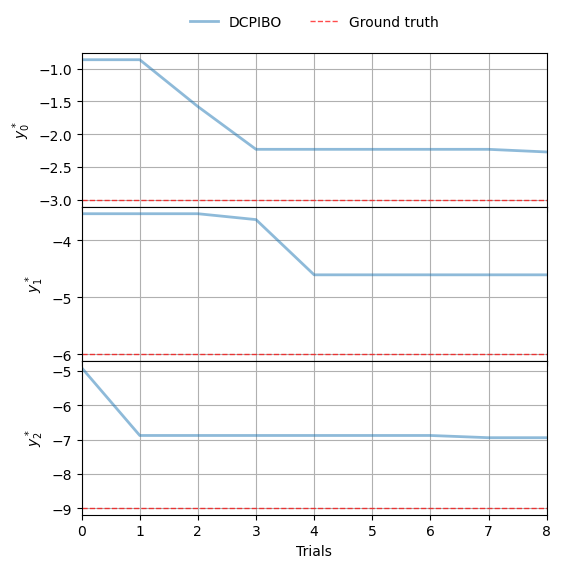

In [47]:
plot_outcome(T,N,outcomes=[dcpibo.optimal_outcome_values_during_trials],labels=['DCPIBO'],true_objective_values=true_objective_values)